## Applying Machine Learning Classification Models
The goal of this notebook is to apply some classification models to two datasets previously prepared. Here is the <a href="http://localhost:8891/notebooks/Desktop/RAFAEL/SPRINGBOARD/Capstone%20Project%202/vehicle-loan-default-prediction/Data%20Preparation.ipynb">link</a> to the notebook where I walk through the data preparation process.<br>
In this notebook I will load the datasets from the Data Preparation Notebook, generate dummy columns, split the datasets into training and testing, define a scoring benchmark, test several models, and elect a winner!<br>
First thing we need to do is to account for the fact that our Dataset is imbalanced, as far as the target column is concerned. We noticed that on the Data Analysis part of the previous Notebook, but we can do a quick bar chart to illustrate this fact:


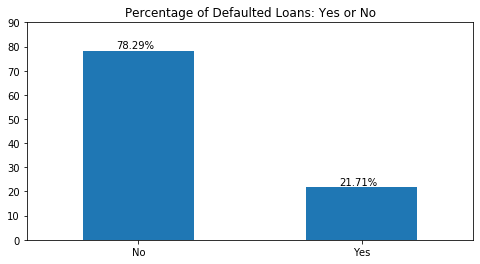

In [135]:
# Bar plot with the number of occurencies of each label ("Yes" or "No") of the target column ("LOAN_DEFAULT")

# Import Pandas and matplotlib.pyplot
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Import raw dataset
df = pd.read_csv("train.csv")

# Plot
ax=plt.subplot(1, 1, 1)
(df.LOAN_DEFAULT.map({0: 'No', 1: 'Yes'}).value_counts()*100/len(df)).plot(kind="bar", 
                                                                           title="Percentage of Defaulted Loans: Yes or No", 
                                                                           rot = 0,
                                                                           ylim = [0,90])
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 2))+"%", ((p.get_x()+p.get_width()/2.-0.1), (p.get_height() + 1)))
    
plt.show()

As the data is imbalanced, I need to take that into account when splitting into train and test dataset. For that, I'll use the module train_test_split from sklearn and, more speciffically, the stratify=y argument, so the proportions of labels are kept on both training and testing dataset.<br>
Below, I define a function that takes care of loading a dataset (specified by its name) and splits into train and test datasets

In [136]:
# Import necessary Libraries
from sklearn.model_selection import train_test_split

# Define a function that loads the dataset, generates dummy columns and split into training and testing
def prepData(file_name, slim=False):
    
    # load datasets into pandas
    df = pd.read_csv(file_name)    
    
    # Identify column "LOAN_DEFAULT" as target
    if("LOAN_DEFAULT" in df.columns):
        y = df.LOAN_DEFAULT
        df = df.drop(labels="LOAN_DEFAULT", axis=1)
    
    # Read the note on the cell below to understand why this part of the code is necessary
    # Remove columns ending in ID from the slim version (Branch ID, Manufacturer ID and State ID)
    if(slim==True):
        
        # Create a list with columns ending in ID
        ID_cols = [col for col in df.columns if col[-2:] == "ID"]
        
        #drop these columns
        df = df.drop(labels=ID_cols, axis=1)
    
    # Generate dummy columns on the categorical columns of df
    if(slim==True):
        df = pd.get_dummies(df, drop_first=True)
    else:
        df = pd.get_dummies(df)    
    
    # Split into trainig and testing
    X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.30, random_state=42, stratify=y, shuffle=True)
    
    return X_train, X_test, y_train, y_test

Notes about this function:<br>
After running this function the first time, I realized that the data type of the columns ending in ID (employee_ID, branch_ID, etc.) were imported as integers. I used the following lines to convert to categorical datatype:<br> 
    
    # Create a list with columns ending in ID
    ID_cols = [col for col in df.columns if col[-2:] == "ID"]

    # Convert to category
    for col in ID_cols:
        df[col] = df[col].astype('category')
   
Once I ran the pd.get_dummies() function, I received a memory error. I tried again with the argument "sparse=True" and the code ran for 20 minutes without resuming, forcing me to interrupt execution. <br><br>
With that in mind, I did the following adaptations to the code:
* df_full --> Columns ending in ID will be kept as integers
* df_slim --> Columns ending in ID will be removed


In [46]:
# Call prepData function for the slim dataset
X_train, X_test, y_train, y_test = prepData("Cleaned-slim.csv", True)

In [124]:
# Call prepData function for the full dataset
X_train, X_test, y_train, y_test = prepData("Cleaned-full.csv")

# PS: THESE CELLS WERE NOT TO EXECUTED IN ORDER. I RAN THE CELL ABOVE FOR ALL THE MODELS, 
# THEN I RAN THIS CELL FOR ALL THE MODELS. I found it easier than specifying different variable names

## Benchmark
I want to beat two benchmarks: Sklearn's DummyClassifier and another one that I will define later.<br> 
First, let's star with the dummy model. The goal is to beat the F1 score (our data is imbalanced, so a combination of precision and recall is the best way to define accuracy. More on this later).<br>
In the cell below, where I build the benchmark model, there are two things to note:
- I am using the best dataset (as defined later)
- I am using a function that is defined in a few cells below to print the most relevant metrics.

In [132]:
from sklearn.dummy import DummyClassifier

# Define and fit dummy classifier
dummy_clf = DummyClassifier(random_state=0).fit(X_train, y_train)

# Print relevant metrics
printData(dummy_clf, X_test, y_test)

total predicted Defaults:  14622
total Defaults on test:  14690
R Squared:  0.6611281929990539
F1Score:  0.2179312227074236
[[41530 11428]
 [11496  3194]]
Recall:  0.21742682096664398


The score to beat is F1Score = 0.218. However, in addition to beating this metric, <b>I want to define a more challenging benchmark: the current model's performance!</b><br>
Before exploring the models, one thing needs to be clear: <b>the raw data comes from actual loans, which means that these records are the current model's prediction = 0 (client will not default)</b>. We don't have the information about how many clients were rejected, so our <b>challenging benchmark will be defined by the raw data and compared to my model's predictions = 0</b>.<br>
With that in mind and after applying a few test models, I noticed a few things:<br>
- A slimmer version of the data is recommended, as the df_slim is outperforming the full df in several models and some models are not converging when using the full dataset. This will be accomplished with the function prepDataSlimmer, defined in the next cell;
- Accuracy will be measured by F1 Score, given that the classes are unbalanced. It account for both the precision and the recall. If we measure accuracy wiht R squared, we could predict only 0 (no loan default) and the accuracy would be 78%, but my model would be useless as far as loan default detection is concerned. To help me with that, I created another function called printData, where the most relevant info about the model's performance is printed.

In [137]:
# Function to remove more columns
def prepDataSlimmer(file_name, extreme=False, no_dummies=False):
    # extreme: When set to True, only the Bureau's Score description column is kept.
    # As a few models were not converging, I felt the need to leave the one column that I am sure that can be used to make
    # good predictions. This way I guarantee I have no noise in the data
    
    # no_dummies: Do not generate dummy columns, needed for comparing my model to the raw's file accuracy
    
    # load datasets into pandas
    df = pd.read_csv(file_name)    
    
    # Identify column "LOAN_DEFAULT" as target
    if("LOAN_DEFAULT" in df.columns):
        y = df.LOAN_DEFAULT
        df = df.drop(labels="LOAN_DEFAULT", axis=1)
    
    # Remove columns ending in ID from the slim version (Branch ID, Manufacturer ID and State ID)
    # Create a list with columns ending in ID
    ID_cols = [col for col in df.columns if col[-2:] == "ID"]
        
    # Drop these columns
    df = df.drop(labels=ID_cols, axis=1)
    
    # List of columns to drop  -  for more noise reduction
    toDrop = ["LTV", "MOBILENO_AVL_FLAG", "AADHAR_FLAG", "PAN_FLAG", "VOTERID_FLAG", "DRIVING_FLAG", "PASSPORT_FLAG"]
    
    df = df.drop(labels=toDrop, axis=1)
    
    # Extreme - leave only the bureau's description, to test models' conversion
    if(extreme == True):
        df = df["PERFORM_CNS_SCORE_DESCRIPTION"]
    
    # Generate dummy columns on the categorical columns of df if no_dummies set to False
    if(no_dummies == False):
        df = pd.get_dummies(df, drop_first=True)    
    
    # Split into trainig and testing
    X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.30, random_state=0, stratify=y, shuffle=True)
    
    return X_train, X_test, y_train, y_test

In [138]:
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score

# Function that prints the relevant data about a model
def printData(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    print("total predicted Defaults: ",sum(y_pred))
    print("total Defaults on test: ", sum(y_test))
    print("R Squared: ", accuracy_score(y_test, y_pred))
    print("F1Score: ", f1_score(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    print("Recall: ", cm[1,1]/(cm[1,0]+cm[1,1]))

In [139]:
# call the function to split into train and test
# Load slim Dataset
X_train, X_test, y_train, y_test = prepDataSlimmer("Cleaned-slim.csv")

In [39]:
# call the function to split into train and test
# Load full Dataset
X_train, X_test, y_train, y_test = prepDataSlimmer("Cleaned-full.csv")

# PS: THESE CELLS WERE NOT TO EXECUTED IN ORDER. I RAN THE CELL ABOVE FOR ALL THE MODELS, 
# THEN I RAN THIS CELL FOR ALL THE MODELS

After running a few models (please check the last cells), I noticed that:
- Considering the models on their "out-of-the-box" versions, SGDClassifier turns out to have the best F1 score.
- <b>The dummy model's F1 score was already beaten by a lot (0.37 > 0.21), even before dataset selection and parameter tweaking.</b>

Now let's improve this model. I want the following answers:
- Which dataset is performing better? Full, slim or slimmer (using function prepDataSlimmer)?
- What parameters can we tweak in the model to make better predictions?
- And finally: <b>Is this model performing better than the current model (challenging benchmark)</b>?

In [126]:
# SGDClassifier  - Full dataset (prepData)
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

clf = make_pipeline(StandardScaler(), SGDClassifier(class_weight='balanced', random_state=42)).fit(X_train, y_train)
printData(clf, X_test, y_test)

total predicted Defaults:  36788
total Defaults on test:  14690
R Squared:  0.5281161305581835
F1Score:  0.3798904386339796
[[25948 27010]
 [ 4912  9778]]
Recall:  0.6656228727025187


In [43]:
# SGDClassifier  - Full dataset, LTV and flags column removed (prepDataSlim)

clf = make_pipeline(StandardScaler(), SGDClassifier(class_weight='balanced', random_state=42)).fit(X_train, y_train)
printData(clf, X_test, y_test)

total predicted Defaults:  36552
total Defaults on test:  14690
Accuracy:  0.5279387417218543
F1Score:  0.3768002810194762
[[26060 26898]
 [ 5036  9654]]
Recall:  0.6571817562968005


In [47]:
# SGDClassifier  - Slim dataset with LTV flags column (predData)

clf = make_pipeline(StandardScaler(), SGDClassifier(class_weight='balanced', random_state=42)).fit(X_train, y_train)
printData(clf, X_test, y_test)

total predicted Defaults:  36567
total Defaults on test:  14690
Accuracy:  0.5363203642384106
F1Score:  0.3880445597674464
[[26336 26622]
 [ 4745  9945]]
Recall:  0.6769911504424779


In [71]:
# SGDClassifier  - Slim dataset, LTV and flags column removed (prepDataSlim)

# BEST MODEL, used from now on. 

# y_pred is defined here!

clf = make_pipeline(StandardScaler(), SGDClassifier(class_weight='balanced', random_state=42)).fit(X_train, y_train)
y_pred = clf.predict(X_test)
printData(clf, X_test, y_test)

total predicted Defaults:  43500
total Defaults on test:  14690
R Squared:  0.46659176915799433
F1Score:  0.3798934524832445
[[20511 32447]
 [ 3637 11053]]
Recall:  0.7524166099387338


## Best dataset
To choose between the last two results, we need to make a decision regarding what we want from this model. The third model has a better R squared and F1 score. However, the <b>fourth model has a 75% Recall rate, which, for our purposes, is better</b>. We want to have a decent accuracy with a strong ability to identify potential defaults, so it makes sense to sacrifice the precision to have a significant increase in the recall rate.<br>
With that in mind, the best result is achieved when I used the <b>Slim dataset without the columns LTV and the ones marked as flags</b>. From now on, I am using this dataset.<br>
Next, we need to see if we can improve this score by tweaking a few parameters.<br>
First, let's inspect the penalty. Maybe an elasticnet will use more of the L1 penalty and reduce a few dimensions.

In [151]:
# SGDClassifier Tweaking: Penalty
parameters = {'l1_ratio':np.arange(0.0, 1.0, 0.1)}
cl = SGDClassifier(class_weight='balanced', penalty='elasticnet', random_state=42)
cl_grid = GridSearchCV(cl, parameters, scoring='f1', cv=5)
clf = make_pipeline(StandardScaler(), cl_grid).fit(X_train, y_train)
print(cl_grid.best_params_)
printData(clf, X_test, y_test)

{'l1_ratio': 0.7000000000000001}
total predicted Defaults:  37471
total Defaults on test:  14690
R Squared:  0.5205327578051088
F1Score:  0.3781752650447652
[[25350 27608]
 [ 4827  9863]]
Recall:  0.6714091218515997


For some reason, GridSearchCV did not choose the best model because the default parameter L2 has a better F1 score (and Accuracy and Recall).<br>
Now let's investigate the parameter alpha, which regulates the "regularization power". 

In [68]:
# SGDClassifier Tweaking: Alpha
parameters = {'alpha':[0.001, 0.01, 0.1]}
cl = SGDClassifier(class_weight='balanced', random_state=42)
cl_grid = GridSearchCV(cl, parameters, scoring='f1', cv=3)
clf = make_pipeline(StandardScaler(), cl_grid).fit(X_train, y_train)
print(cl_grid.best_params_)
printData(clf, X_test, y_test)

{'alpha': 0.01}
total predicted Defaults:  40360
total Defaults on test:  14690
R Squared:  0.49866958372753073
F1Score:  0.3839418710263397
[[23166 29792]
 [ 4122 10568]]
Recall:  0.7194009530292717


We notice that, even though there is a slight increase in the F1 score, the recall rate decreases. The trade-off is not good enough to discard the default alpha, which is 0.0001.<br>
With that, the only non-default parameter is the class_weight, which accounts for our imbalanced datasets.<br>

## Models comparison
### Overall Default Rate Prediction accuracy
We defined the best dataset and the best parameters. Now we need to check if our predictions are better than the current model's predictions. Here is how I'll calculate this: <br>
Considering all the 0 in my model (loans predicted as non-default), my precision would be 3637/(3637+20511) ~ <b>15%</b> (numbers extracted from the confusion matrix), <b>significantly lower than the 21.7% default rate we observe in the raw data</b>. My model makes 50 % error when it comes to identify non-default customers, but is 75% accurate to identify customers likely to default. We don't have these metrics regarding the model that originated the raw data, so let's be happy with what we got :) <br>
### Default Rate Prediction accuracy by Credit Score Bins
For the last part of this Notebook, I want to see how the two models behave for each credit score bin. I want to see how accurate my model is for each score bin when my prediction is 0 (non-default loan). The goal here is to have a plot similar to what I produced in the "Data Preparation" Notebook, but now with two curves: one for the raw data, another one for my predictions. And may the best one win!


In [98]:
# First, let's define a function to build a dictionary where the keys = bin and values = Default Rate 
def buildDict(df, bins):
# Arguments description:
#  - df - DataFrame that contains the data
#  - bins - how the data is grouped. Very important to note: only the first 20 characters of the score bin description
# is kept, otherwise the plot gets messy with too much text
    
    #create an empty dictionary
    aDict = {}
    
    #loop through bins
    for bin in bins:
        # For each bin, calculate the total defaults / total data points in that bin            
        aDict[bin[:20]] = 100*(sum(df[df['PERFORM_CNS_SCORE_DESCRIPTION'] == bin]["LOAN_DEFAULT"])/
                              df[df['PERFORM_CNS_SCORE_DESCRIPTION'] == bin]["LOAN_DEFAULT"].count())         
    
    return aDict

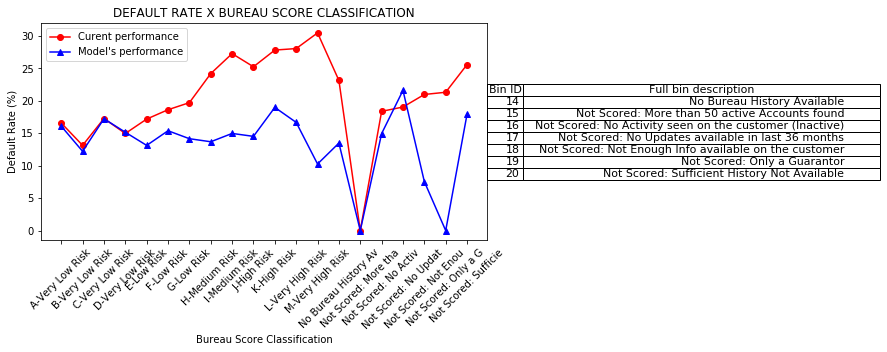

In [115]:
# Now let's build the plot with the two curves. The whole raw dataset is used to plot the ACTUAL default rate per 
# bin, whereas the PREDICTION uses only the records where prediction = 0.

import matplotlib.pyplot as plt

# Load the raw data
df_actual = pd.read_csv("train.csv", header=0, index_col=0)

# Define the bins from PERFORM_CNS_SCORE_DESCRIPTION column
score_bins = [bin for bin in sorted(df_actual.PERFORM_CNS_SCORE_DESCRIPTION.unique())]

# Run the function to define X_test again, now without the pd.get_dummies (otherwise the column
# PERFORM_CNS_SCORE_DESCRIPTION won't exist, only the "dummy versions" of it)
X_train, X_test, y_train, y_test = prepDataSlimmer("Cleaned-slim.csv", extreme=False, no_dummies=True)

# Add columns "PREDICTION" and "LOAN_DEFAULT" (which is y_test) to X_test
X_test["PREDICTION"] = y_pred
X_test["LOAN_DEFAULT"] = y_test

# Keep the records where prediction is 0 (no loan default)
df_pred = X_test[X_test.PREDICTION == 0]

# Build dictionary for actual values and predictions values
actualDict = buildDict(df_actual, score_bins)
predDict = buildDict(df_pred, score_bins)

# Built plot
fig=plt.figure()
ax=fig.add_subplot(111)

# Curves
ax.plot(list(actualDict.keys()), list(actualDict.values()),c='r',ls='-', marker="o", label = 'Curent performance')
ax.plot(list(actualDict.keys()), list(predDict.values()),c='b',ls='-', marker="^", label = 'Model\'s performance')

# Decorations
plt.xticks(rotation=45)
plt.ylabel("Default Rate (%)")
plt.xlabel("Bureau Score Classification")
plt.title("DEFAULT RATE X BUREAU SCORE CLASSIFICATION")
plt.rcParams["figure.figsize"] = (8,4)
plt.legend(loc=2)

# Table with full bin description
# Create a list of bin description that got truncated
full_descr = [x for x in sorted(df_actual.PERFORM_CNS_SCORE_DESCRIPTION.unique()) if(x[0] == 'N')]

# Create table
the_table = plt.table(cellText=list(zip(np.arange(14,21), full_descr)),
                      colLabels=["Bin ID","Full bin description"],
                      loc = 'right',
                      colWidths = [0.08,0.8])
the_table.auto_set_font_size(False)
the_table.set_fontsize(11)
plt.show()

As far as estimating the probability of a loan default is concerned, it is very easy to notice that <b>my model outperform the current model in almost all ranges of credit score</b>. Even when the customer is not scored (please check the several reasons why a customer may not be scored on the table to the right of the plot), following my predictions would result in a lower default rate.

# Conclusion

From the technical perspective, it came to me as a surprise that the <b>slimmer version of the dataset, with just a few features, would yield the best prediction</b>. As our personal computers have sufficient processing power nowadays, we have a tendency to use all the features we have and, in this particular case, this proved to be a bad strategy. <br>
As a final note, here is what I would recommend: If a customer asks for a loan, first run my model. If the prediction is zero, maybe a special rate could be applied because the probability of a loan default is very low (15%). However, as noted when the confusion matrix was presented, this model makes a considerable amount of false negative predictions. Even though it detects 75% of true negatives, only one out of three default predictions are true negatives. That being said, further investigation should be done when the prediction is 1, in case the number of clients being rejected is considered "bad for the business". Maybe another model could be generated for these predictions, along with a "Loan Interest Rate X Default Risk" analysis. Needless to say this is out of the scope of this project.

# Appendix
Please find below all the models tested. Each of these cells were ran several times, with a few combinations of line codes. For that reason, some lines are commented out, but I kept it in the code so we can have a hint of what was tested.

In [140]:
# Trial 1 - grid search CV with logistic regression - Poor performance or did not converge
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

#parameters = {'solver':('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga')}
clf = LogisticRegression(random_state=42, max_iter=300, solver='sag').fit(X_train, y_train)
#clf = GridSearchCV(cl, parameters, cv=3).fit(X_train, y_train)

#y_pred 

# y_pred = clf.predict(X_test)
# print(sum(y_pred))
# #result = 0 for both extreme = True or False

#y_prob
#y_prob = clf.predict_proba(X_test)
# print(np.average(y_prob[:,1])
#print(np.sort(y_prob[:,1])[-10:])
#print(np.count_nonzero(y_prob[y_prob[:,1] > 0.2]))

#print(clf.best_params_)
# print(sum(clf.predict(X_test)))
# print(clf.score(X_test, y_test))

printData(clf,X_test, y_test )

total predicted Defaults:  0
total Defaults on test:  14690
R Squared:  0.7828464995269631
F1Score:  0.0
[[52958     0]
 [14690     0]]
Recall:  0.0


C:\Users\Rafael\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Rafael\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [141]:
#trial 2 - K neighbors  -  very poor performance
from sklearn.neighbors import KNeighborsClassifier

#parameters = {'n_neighbors':np.arange(3, 7, 2)}
#, 'weights':('uniform', 'distance')
#cl = KNeighborsClassifier(n_neighbors=5)
clf = KNeighborsClassifier(n_neighbors=5).fit(X_train, y_train)
#clf = GridSearchCV(cl, parameters, cv=3).fit(X_train, y_train)

#print(clf.best_params_)
# y_pred = clf.predict(X_test)
# print(sum(y_pred))
# print(sum(y_test))
# print(clf.score(X_test, y_test))
# print(f1_score(y_test, y_pred))
printData(clf, X_test, y_test)

total predicted Defaults:  5801
total Defaults on test:  14690
R Squared:  0.7436583491012299
F1Score:  0.15372602606022157
[[48732  4226]
 [13115  1575]]
Recall:  0.10721579305650102


In [146]:
#trial 4 - Perceptron  -  Good performance
from sklearn.linear_model import Perceptron

clf = Perceptron(tol=1e-3, random_state=42, class_weight={0:1,1:3}).fit(X_train, y_train)
#penalty = ’elasticnet’
printData(clf, X_test, y_test)

total predicted Defaults:  40831
total Defaults on test:  14690
R Squared:  0.45235631504257334
F1Score:  0.3327389636353812
[[21364 31594]
 [ 5453  9237]]
Recall:  0.6287950987066031


In [143]:
#trial 5.1 - Linear Discriminat Analysis - prior tweaking -  DID NOT RUN FOR FULL DATASET - "VARIABLES ARE COLLINEAR"
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
parameters = {'priors':[[x,1-x] for x in np.arange(0.2, 0.5, 0.1)]}

cl = LinearDiscriminantAnalysis()
clf = GridSearchCV(cl, parameters, scoring='f1', cv=3).fit(X_train, y_train)

print(clf.best_params_)
printData(clf, X_test, y_test)

{'priors': [0.4000000000000001, 0.5999999999999999]}
total predicted Defaults:  55061
total Defaults on test:  14690
R Squared:  0.3603210737937559
F1Score:  0.3796074608249344
[[11136 41822]
 [ 1451 13239]]
Recall:  0.9012253233492171


In [147]:
#trial 5.2 - Linear Discriminat Analysis  -  No priors tweaking
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

clf = LinearDiscriminantAnalysis().fit(X_train, y_train)
print(clf.priors_)

printData(clf, X_test, y_test)

[0.78284393 0.21715607]
total predicted Defaults:  135
total Defaults on test:  14690
R Squared:  0.7824473746452223
F1Score:  0.007284991568296796
[[52877    81]
 [14636    54]]
Recall:  0.0036759700476514637


TO NOTE: 
- When I use grid search to find the best prior, I have [0.4 , 0.6]. Why so different than training set priors [0.78, 0.22]? When I split the data into training and testing, I use stratify=y, shuffle=True. Training and Testing priors should be closer

In [148]:
# Trial 6 - Random Forest Classifier  -  Very poor performance, when ran with max_depth = 3 
# I had no prediction for the positive class
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=0, n_estimators=100).fit(X_train, y_train)

printData(clf, X_test, y_test)

total predicted Defaults:  1274
total Defaults on test:  14690
R Squared:  0.7784117786187322
F1Score:  0.06101227762465548
[[52171   787]
 [14203   487]]
Recall:  0.03315180394826413


In [149]:
# Trial 7 -  Multi-layer Perceptron classifier  -  Very poor performance
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(random_state=42, max_iter=300).fit(X_train, y_train)

printData(clf, X_test, y_test)

total predicted Defaults:  3
total Defaults on test:  14690
R Squared:  0.7828317171239356
F1Score:  0.00013611924045463825
[[52956     2]
 [14689     1]]
Recall:  6.807351940095303e-05


In [150]:
# Trial 8 -  Gradient Boosting Classifier  -  Very poor performance
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(random_state=42).fit(X_train, y_train)

printData(clf, X_test, y_test)

total predicted Defaults:  80
total Defaults on test:  14690
R Squared:  0.7829056291390728
F1Score:  0.005687203791469195
[[52920    38]
 [14648    42]]
Recall:  0.0028590878148400272


In [101]:
# Trial 9.1 - Support Vector Machine,gridCV - Took too long, interrupted.
from sklearn.svm import SVC

parameters = {'gamma':['scale', 'auto']}
cl = SVC()
clf = GridSearchCV(cl, parameters, scoring='f1', cv=3).fit(X_train, y_train)

print(clf.best_params_)
printData(clf, X_test, y_test)

KeyboardInterrupt: 

In [103]:
# Trial 9.2 - Support Vector Machine,gridCV and Scaler - Took too long, interrupted.
from sklearn.svm import SVC

parameters = {'gamma':['scale', 'auto']}
cl = SVC(class_weight='balanced')  # or try different penalty parameters C
cl_grid = GridSearchCV(cl, parameters, scoring='f1', cv=3)
clf = make_pipeline(StandardScaler(), cl_grid).fit(X_train, y_train)

print(clf.best_params_)
printData(clf, X_test, y_test)


KeyboardInterrupt: 

In [ ]:
# Trial 9.3 - Support Vector Machine, Scaler - Took too long, interrupted.
from sklearn.svm import SVC

cl = SVC(class_weight='balanced')  # or try different penalty parameters C
clf = make_pipeline(StandardScaler(), cl).fit(X_train, y_train)

print(clf.best_params_)
printData(clf, X_test, y_test)